# Importing data

In [20]:
import pandas as pd
train_data = pd.read_csv("/Users/niki/code/Niki827/watt_squad/raw_data/train.csv")
test_data = pd.read_csv("/Users/niki/code/Niki827/watt_squad/raw_data/test.csv")

# Preprocessing data

In [21]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

## lists of features:


# f_time = ['time']


## our custom functions:

def log_transformed(data):
    """ replaces values in columns in a dataframe with the log values """
    f_logs = [
    'precip_1h:mm',
    'prob_precip_1h:p',
    'clear_sky_rad:W',
    'clear_sky_energy_1h:J',
    'diffuse_rad:W',
    'diffuse_rad_1h:Wh',
    'direct_rad:W',
    'direct_rad_1h:Wh',
    'global_rad:W',
    'global_rad_1h:Wh',
    'wind_speed_2m:ms',
    'wind_speed_10m:ms',
    'wind_speed_50m:ms',
    'wind_speed_100m:ms'
]
    for col in f_logs:
        data[col] = np.log(data[col] + 1e-5)
    return data

def time_transformed(data):
    """takes a df and splits the 'time' feature into three features: hour, month, season;
    drops the original time column"""

    feature = pd.to_datetime(data.time)

    hour = feature.dt.hour
    month  = feature.dt.month

    def assign_season(month):
        if month in [3, 4, 5]:
            return 1  # Spring
        elif month in [6, 7, 8]:
            return 2  # Summer
        elif month in [9, 10, 11]:
            return 3  # Fall
        else:  # December, January, February
            return 4  # Winter

    season = month.apply(assign_season)
    hour_sine = np.sin(2 * np.pi * hour / 24)
    hour_cosine = np.cos(2 * np.pi * hour / 24)
    month_sine = np.sin(2 * np.pi * month / 12)
    month_cosine = np.cos(2 * np.pi * month / 12)
    season_sine = np.sin(2 * np.pi * season / 4)
    season_cosine = np.cos(2 * np.pi * season / 4)

    data["hour_sine"] = hour_sine
    data["hour_cosine"] = hour_cosine
    data["month_sine"] = month_sine
    data["month_cosine"] = month_cosine
    data["season_sine"] = season_sine
    data["season_cosine"] = season_cosine

    data = data.drop(columns=["time"])

    return data

def degree_transformed(data):
    """ takes a df 'data' and takes the features with degree units (in the specific list f_degree);
    creates a sin and cos column for each to make them cyclical. drops the original columns"""

    f_degree = ['sun_azimuth:d', 'wind_dir_2m:d', 'wind_dir_10m:d', 'wind_dir_50m:d', 'wind_dir_100m:d']

    for col in f_degree:
        sin_column = np.sin(2 * np.pi * data[col]/360)
        cos_column = np.cos(2 * np.pi * data[col]/360)

        data[f"sin_{col}"] = sin_column
        data[f"cos_{col}"] = cos_column
        data = data.drop(columns=[col])

    return data

def transform_data(data):
    """ applies the above three functions to the input dataframe """
    data = degree_transformed(time_transformed(log_transformed(data)))

    all_col = list(data.columns)

    # defining the columns we don't want in our X_train
    drop_col = ['pv_production',
            'wind_production',
            'consumption',
            'spot_market_price',
            'precip_type:idx']

    f_ohe = ['precip_type:idx']

    scale_col = [col for col in all_col if col not in drop_col and f_ohe]

    # defining our scalers
    minmax = MinMaxScaler()
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output = False)


    # our preproc pipline
    preproc = make_column_transformer(
        (ohe, f_ohe),
        (minmax, scale_col),
        remainder = "drop"
    )

    data_transformed = preproc.fit_transform(data)
    data_transformed = pd.DataFrame(data_transformed, columns=preproc.get_feature_names_out())
    data_transformed['onehotencoder__precip_type:idx_2.0'] = 0

    print('➡️ preprocessing done')
    return data_transformed



# ## building the pipeline

# data = pd.read_csv("raw_data/train.csv")

# # calling our custom functions on our dataframe
# data_ft = degree_transformed(time_transformed(log_transformed(data)))

# all_col = list(data_ft.columns)

# # defining the columns we don't want in our X_train
# drop_col = ['pv_production',
#             'wind_production',
#             'consumption',
#             'spot_market_price',
#             'precip_type:idx']

# # defining the columns we want to scale
# scale_col = [col for col in all_col if col not in drop_col and f_ohe]

# # defining our scalers
# minmax = MinMaxScaler()
# ohe = OneHotEncoder(handle_unknown='ignore', sparse_output = False)

# # our preproc pipline
# preproc = make_column_transformer(
#     (ohe, f_ohe),
#     (minmax, scale_col),
#     remainder = "drop"
# )

# data_transformed = preproc.fit_transform(data_ft)
# data_transformed = pd.DataFrame(data_transformed, columns=preproc.get_feature_names_out())


# Creating datasets

In [22]:
# creating y_train and y_test
y_train = train_data['wind_production'].copy()
y_test = test_data['wind_production'].copy()

# creating X_train and X_test
X_train = train_data
X_train = X_train.drop(columns=['pv_production', 'wind_production', 'consumption', 'spot_market_price'])
X_test = test_data
X_test = X_test.drop(columns=['pv_production', 'wind_production', 'consumption', 'spot_market_price'])

# Preprocessing features
X_train_transformed = transform_data(X_train)
X_test_transformed = transform_data(X_test)

➡️ preprocessing done
➡️ preprocessing done


In [23]:
#Creating X_val and y_val
X_train_transformed, X_val, y_train, y_val = train_test_split(
X_train_transformed, y_train, test_size = 0.1, random_state = 42  # val = 10%
)

# Grid search model

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [25]:
# Initialize the model with the best parameters from grid search
xgb_reg = XGBRegressor(
    max_depth=7,                # Optimal value found
    n_estimators=300,           # Optimal value found
    learning_rate=0.05,         # Optimal value found
    reg_alpha=0.05,             # Optimal value found
    reg_lambda=20,              # Optimal value found
    subsample=0.8,              # Optimal value found
    colsample_bytree=0.8,       # Optimal value found
    objective='reg:squarederror',
    eval_metric="mae",
    random_state=42             # Ensuring reproducibility
)

# Fit the model on the training data
xgb_reg.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_train_transformed, y_train), (X_val, y_val)],
    verbose=True,
    early_stopping_rounds=5     # Retain early stopping
)

print("➡️  model fitting done")

# Make predictions
y_pred = xgb_reg.predict(X_test_transformed)

print("➡️  performed predictions")

[0]	validation_0-mae:20.93945	validation_1-mae:21.49838
[1]	validation_0-mae:20.36492	validation_1-mae:20.89643
[2]	validation_0-mae:19.75468	validation_1-mae:20.26441
[3]	validation_0-mae:19.18657	validation_1-mae:19.66701
[4]	validation_0-mae:18.65767	validation_1-mae:19.11782
[5]	validation_0-mae:18.14998	validation_1-mae:18.60914
[6]	validation_0-mae:17.68855	validation_1-mae:18.14365
[7]	validation_0-mae:17.26929	validation_1-mae:17.69824
[8]	validation_0-mae:16.85448	validation_1-mae:17.29276
[9]	validation_0-mae:16.48657	validation_1-mae:16.89540
[10]	validation_0-mae:16.15221	validation_1-mae:16.54402
[11]	validation_0-mae:15.81590	validation_1-mae:16.19459
[12]	validation_0-mae:15.50403	validation_1-mae:15.89827
[13]	validation_0-mae:15.24556	validation_1-mae:15.63539
[14]	validation_0-mae:14.97980	validation_1-mae:15.37121
[15]	validation_0-mae:14.73615	validation_1-mae:15.15182
[16]	validation_0-mae:14.50229	validation_1-mae:14.91040


/Users/niki/.pyenv/versions/3.10.6/envs/watt_squad/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-mae:14.27685	validation_1-mae:14.73265
[18]	validation_0-mae:14.06572	validation_1-mae:14.51945
[19]	validation_0-mae:13.87125	validation_1-mae:14.33988
[20]	validation_0-mae:13.69185	validation_1-mae:14.18485
[21]	validation_0-mae:13.51694	validation_1-mae:14.01904
[22]	validation_0-mae:13.35339	validation_1-mae:13.86662
[23]	validation_0-mae:13.22820	validation_1-mae:13.75378
[24]	validation_0-mae:13.09084	validation_1-mae:13.62200
[25]	validation_0-mae:12.95647	validation_1-mae:13.49604
[26]	validation_0-mae:12.84119	validation_1-mae:13.40406
[27]	validation_0-mae:12.72234	validation_1-mae:13.29603
[28]	validation_0-mae:12.61226	validation_1-mae:13.18243
[29]	validation_0-mae:12.49564	validation_1-mae:13.08693
[30]	validation_0-mae:12.39659	validation_1-mae:12.98133
[31]	validation_0-mae:12.29715	validation_1-mae:12.88623
[32]	validation_0-mae:12.20099	validation_1-mae:12.79738
[33]	validation_0-mae:12.11109	validation_1-mae:12.70969
[34]	validation_0-mae:12.02327	

# Most important features

In [26]:
importance = xgb_reg.feature_importances_
feature_names = X_train_transformed.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

In [27]:
importance_df

,Feature,Importance
36,minmaxscaler__wind_speed_100m:ms,0.177195
32,minmaxscaler__wind_speed_50m:ms,0.105039
40,minmaxscaler__month_cosine,0.064014
52,minmaxscaler__cos_wind_dir_100m:d,0.045360
47,minmaxscaler__sin_wind_dir_10m:d,0.037024
42,minmaxscaler__season_cosine,0.035606
3,onehotencoder__precip_type:idx_3.0,0.026265
24,minmaxscaler__wind_speed_2m:ms,0.025258
25,minmaxscaler__t_10m:C,0.025057
48,minmaxscaler__cos_wind_dir_10m:d,0.024520


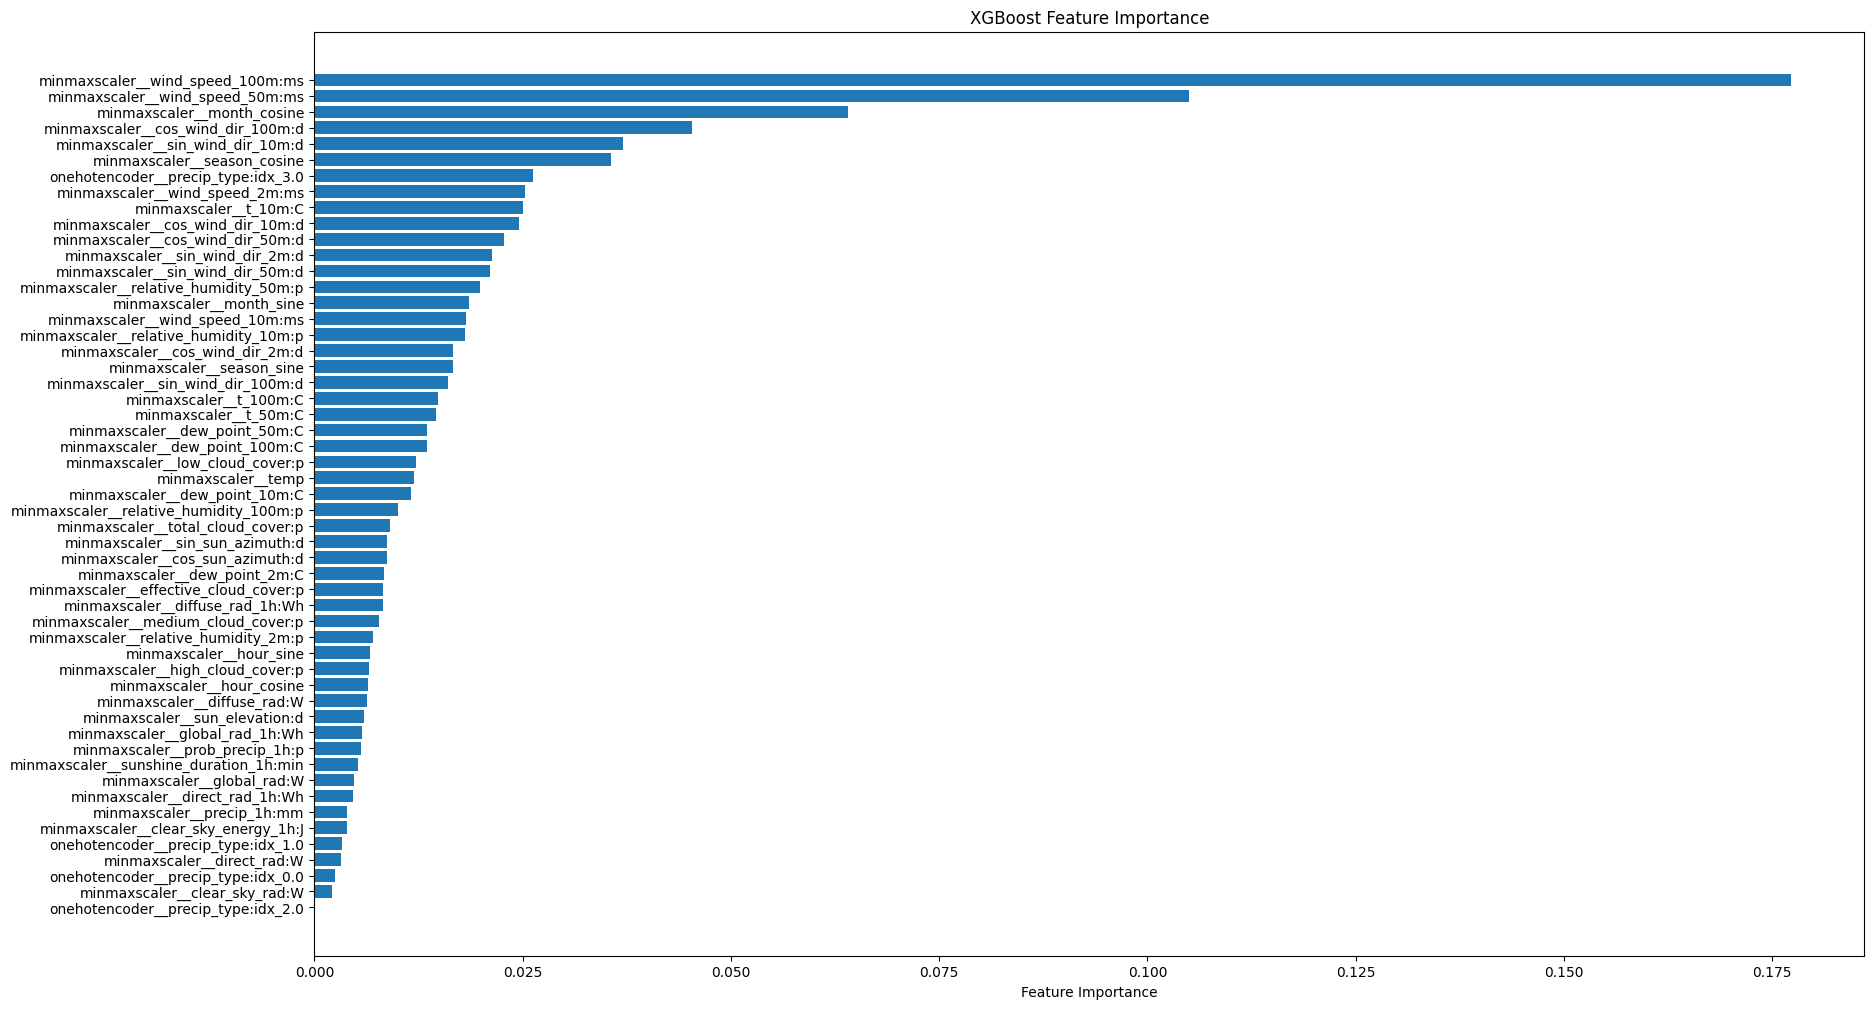

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

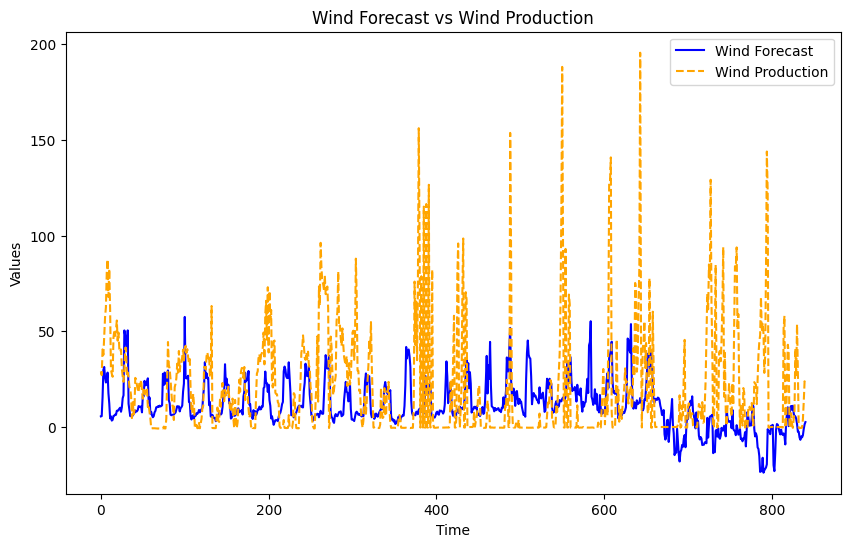

In [29]:
predictions_df = pd.read_csv("~/code/Niki827/watt_squad/raw_data/test.csv")
predictions_df = predictions_df[['time']]
predictions_df['wind_forecast'] = y_pred

y_plot = pd.read_csv('~/code/Niki827/watt_squad/raw_data/test.csv')


import matplotlib.pyplot as plt

# Assuming predictions_df and y_plot are your DataFrames
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the 'pv_forecast' column
plt.plot(predictions_df['wind_forecast'], label='Wind Forecast', color='blue', linestyle='-')

# Plot the 'pv_production' column
plt.plot(y_plot['wind_production'], label='Wind Production', color='orange', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Wind Forecast vs Wind Production')
plt.legend()

# Display the plot
plt.show()